In [1]:
import torch
from torch import nn
from typing import List, Tuple, Dict
from torch.nn import functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from skorch import NeuralNet
from skorch.dataset import CVSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np


torch.cuda.is_available()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
trainset = MNIST(root = '../data', train = True, download = True, transform = transforms.ToTensor())
testset  = MNIST(root = '../data', train = False, download = True, transform = transforms.ToTensor())

batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)

Teste com um autoencoder normal para ter um parâmetro.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dim)

    def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
#         return z.reshape((-1, 1, 28, 28))
        return z


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [4]:
skorch_model = NeuralNet(
    module = Autoencoder,
    module__latent_dim  = 500,
    criterion = nn.MSELoss,
    optimizer = torch.optim.Adam,
    lr = 0.01,
    max_epochs = 100,
    batch_size = 10000,
    iterator_train__shuffle=True,
    train_split = CVSplit(0.33),
    device = device,
    verbose = True
)

scaler = MinMaxScaler()
# scaler = StandardScaler()

A = trainloader.dataset.data.reshape(len(trainset), -1).float().numpy()
scaler.fit(A)
A = scaler.transform(A)

skorch_model.fit(A, A)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1358        0.0807  3.0824
      2        0.0793        0.0711  1.1335
      3        0.0670        0.0622  1.0786
      4        0.0615        0.0600  1.0530
      5        0.0592        0.0578  1.1040
      6        0.0576        0.0563  1.0774
      7        0.0552        0.0534  1.0329
      8        0.0529        0.0512  1.0500
      9        0.0507        0.0493  1.0537
     10        0.0487        0.0471  1.1115
     11        0.0462        0.0452  1.0795
     12        0.0449        0.0437  1.0963
     13        0.0432        0.0424  1.1180
     14        0.0420        0.0417  1.0608
     15        0.0419        0.0411  1.0966
     16        0.0404        0.0396  1.0611
     17        0.0391        0.0386  1.0914
     18        0.0395        0.0387  1.1446
     19        0.0380        0.0374  1.0128
     20        0.0368        0.0361  1.0427
     21        0.0359        0.0

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Autoencoder(
    (encoder): Encoder(
      (linear1): Linear(in_features=784, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=500, bias=True)
    )
    (decoder): Decoder(
      (linear1): Linear(in_features=500, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=784, bias=True)
    )
  ),
)

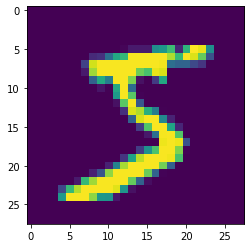

In [5]:
plt.imshow(A[0].reshape(28, 28))

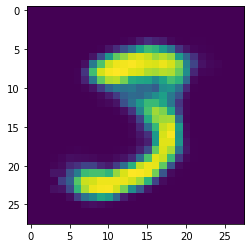

In [6]:
plt.imshow(skorch_model.forward(A[0]).reshape(28, 28))

Autoencoder Variacional

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim: int = 43, latent_dim: int = 30, hidden_dims: List[int] = [40, 35]) -> None:
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        modules = []
        for h_dim in hidden_dims:
            modules.append(nn.Sequential(
                nn.Linear(input_dim, h_dim),
                nn.Dropout(0.1),
                nn.ReLU()
            ))
            input_dim = h_dim
            
        self.Encoder = nn.Sequential(*modules)
        
        self.mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.log_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        
        modules = []
        modules.append(nn.Linear(latent_dim, hidden_dims[-1]))
        hidden_dims.reverse()
        hidden_dims.append(self.input_dim)
        for i in range(len(hidden_dims) - 1):
            modules.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i + 1]),
                nn.ReLU()
            ))
        self.Decoder = nn.Sequential(*modules)
        
        if device == 'cuda':
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
            self.Encoder = self.Encoder.cuda()
            self.Decoder = self.Decoder.cuda()
        
        
    def forward(self, X: torch.Tensor) -> Tuple[torch.Tensor]:
        X = self.Encoder(X)
        mu = self.mu(X)
        log_var = self.log_var(X)
        sigma = torch.exp(0.5 * log_var)
        
        Z = mu + sigma * self.N.sample(mu.shape)
        
        X = self.Decoder(Z)
        
        return X, mu, sigma
    
class VAELoss(nn.Module):
    def __init__(self) -> None:
        super(VAELoss, self).__init__()
    
    def forward(self, model_output, X) -> torch.Tensor:
        Xhat, mu, log_var = model_output
        KL_Divergence = - 0.5 * (1 + log_var - mu.pow(2) - log_var.exp()).mean()
        Reconstruction_Loss = F.mse_loss(Xhat, X)
        
        loss = Reconstruction_Loss + KL_Divergence
        
        return loss

In [8]:
skorch_model = NeuralNet(
    module = VariationalAutoencoder,
    module__input_dim   = 784,
    module__hidden_dims = [768, 720, 700],
    module__latent_dim  = 650,
    criterion = VAELoss,
    optimizer = torch.optim.Adam,
    lr = 0.0001,
    max_epochs = 300,
    batch_size = 7000,
    iterator_train__shuffle=True,
    train_split = CVSplit(0.33),
    device = device
)

scaler = MinMaxScaler()
# scaler = StandardScaler()

A = trainloader.dataset.data.reshape(len(trainset), -1).float().numpy()
scaler.fit(A)
A = scaler.transform(A)

In [9]:
skorch_model.fit(A, A)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4604        0.4491  1.8569
      2        0.4385        0.4176  1.7697
      3        0.3960        0.3547  1.7630
      4        0.3173        0.2476  1.7972
      5        0.2086        0.1352  1.7793
      6        0.1378        0.0849  1.8012
      7        0.1314        0.0775  1.7158
      8        0.1236        0.0772  1.8214
      9        0.1106        0.0806  1.7624
     10        0.1043        0.0839  1.8223
     11        0.1015        0.0824  1.7352
     12        0.0981        0.0782  1.8000
     13        0.0952        0.0750  1.7245
     14        0.0932        0.0733  1.8786
     15        0.0914        0.0732  1.7561
     16        0.0897        0.0731  1.8078
     17        0.0883        0.0726  1.7425
     18        0.0870        0.0718  1.8305
     19        0.0857        0.0707  1.7491
     20        0.0844        0.0698  1.8849
     21        0.0830        0.0

<class 'skorch.net.NeuralNet'>[initialized](
  module_=VariationalAutoencoder(
    (Encoder): Sequential(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=768, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=768, out_features=720, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=720, out_features=700, bias=True)
        (1): Dropout(p=0.1, inplace=False)
        (2): ReLU()
      )
    )
    (mu): Linear(in_features=700, out_features=650, bias=True)
    (log_var): Linear(in_features=700, out_features=650, bias=True)
    (Decoder): Sequential(
      (0): Linear(in_features=650, out_features=700, bias=True)
      (1): Sequential(
        (0): Linear(in_features=700, out_features=720, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=720, out_featu

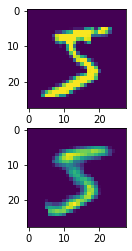

In [14]:
idx = 0
fig, axs = plt.subplots(nrows = 2)
axs[0].imshow(A[idx].reshape(28, 28))
K = skorch_model.module_(torch.tensor(A[idx], device = device))[0].reshape(28, 28).detach().cpu().numpy()
axs[1].imshow(K)

In [15]:
N = torch.distributions.Normal(0, 1)

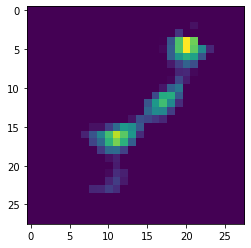

In [17]:
z = N.sample(sample_shape = (1, 650)).cuda()
S = skorch_model.module_.Decoder(z)[0].reshape(28, 28).detach().cpu().numpy()
plt.imshow(S)